# Table of Contents
 <p><div class="lev1"><a href="#Load-data-(pick-the-pairing-score-table-below!)"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data (pick the pairing score table below!)</a></div><div class="lev1"><a href="#Define-plotting-functions"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define plotting functions</a></div><div class="lev1"><a href="#Plot"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></div><div class="lev2"><a href="#Output-quadrants"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Output quadrants</a></div><div class="lev2"><a href="#Batch-plot"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Batch plot</a></div>

In [3]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import seaborn.apionly as sns
mpl.style.use('seaborn-talk')
pal = sns.palettes.get_color_cycle()

import numpy as np
import pandas as pd
import scipy.stats as st

import cooler
import bioframe

import cooltools
import cooltools.num.numutils

import pathlib

In [4]:
# add fall colormap
import matplotlib

def listToColormap(colorList, cmapName=None):
    colorList = np.array(colorList)
    if colorList.min() < 0:
        raise ValueError("Colors should be 0 to 1, or 0 to 255")
    if colorList.max() > 1.:
        if colorList.max() > 255:
            raise ValueError("Colors should be 0 to 1 or 0 to 255")
        else:
            colorList = colorList / 255.
    return matplotlib.colors.LinearSegmentedColormap.from_list(cmapName, colorList, 256)

fallList = [
     (255, 255, 255), (255, 255, 204),
     (255, 237, 160), (254, 217, 118),
     (254, 178, 76), (253, 141, 60),
     (252, 78, 42), (227, 26, 28),
     (189, 0, 38), (128, 0, 38), (0, 0, 0)]


def registerList(mylist, name):
    mymap = listToColormap(mylist, name)
    mymapR = listToColormap(mylist[::-1], name + "_r")
    mymapR.set_bad('white',1.)
    mymap.set_bad('white',1.)
    matplotlib.cm.register_cmap(name, mymap)
    matplotlib.cm.register_cmap(name + "_r", mymapR)

registerList(fallList, "fall")

coolwarm = matplotlib.cm.coolwarm
coolwarm.set_bad('white',1.)
matplotlib.cm.register_cmap('coolwarm', coolwarm)

def select_finite(z):
    return z[np.isfinite(z)]

def gridspec_inches(
    wcols,
    hrows,
    fig_kwargs={}):

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    fig_height_inches = (
        sum(hrows)
        )

    fig_width_inches = (
        sum(wcols)
        )

    fig=plt.figure(
        figsize=(fig_width_inches,fig_height_inches),
        subplotpars=mpl.figure.SubplotParams(
        left=0,
        right=1,
        bottom=0,
        top=1,
        wspace =0,
        hspace = 0.0),
        frameon=False,
        **fig_kwargs)
    fig.set_size_inches(fig_width_inches,fig_height_inches,forward=True)

    gs = mpl.gridspec.GridSpec(
        len(hrows),
        len(wcols),
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=0,
        hspace=0,
        width_ratios=wcols,
        height_ratios=hrows
        )

    return fig, gs


# Load data (pick the pairing score table below!)

In [5]:
dm3_chromsizes = bioframe.read_chromsizes(
    '/net/levsha/share/lab/genomes/dm3/dm3.chrom.sizes.higlass',
    all_names=True)


dm3_057_439_chromsizes = bioframe.read_chromsizes(
    '/net/levsha/share/lab/genomes/phased/dm3-057-439-JJ-snps-hybrid/dm3_057_439-JJ-snps-hybrid.chromsizes',
    all_names=True)

In [47]:
RES = 4000
pairing_JJ17_18 = pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/pairing-057-439/tables/JJ17_18.log2_pairing.res_{}.win_24000.balanced.3R_adj.nonorm.per_hom.nanmean.tsv'.format(RES),
    comment='#'
    
)

pairing_JJ25_26 = pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/pairing-057-439/tables/JJ25_26.log2_pairing.res_{}.win_24000.balance.nonorm.per_hom.nanmean.tsv'.format(RES),
    comment='#'
    
)
eigs= pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/eigs/dm3/JJ17_18.ciseigs.{}.clip_99.genedens_sort.tsv'.format(RES)
)

# Define plotting functions

In [48]:
def get_bin_data(bw_path, pairing, use_chrX=True):
    x = None
    y = None
    chroms = ['chr2L','chr2R','chr3L','chr3R']
    if use_chrX:
        chroms += ['chrX']
    for chrom in chroms:
        start = 0
        end = dm3_chromsizes[chrom]

        loc_pairing = bioframe.slice_bedframe(pairing, (chrom+'_057', start, end)).pairing.values

        loc_chip = bioframe.read_bigwig_binned(
            bw_path,
            chrom,
            start,
            end,
            int(np.ceil((end-start)/RES))
        )

        x = np.log10(loc_chip) if x is None else np.r_[x, np.log10(loc_chip)]
        y = loc_pairing        if y is None else np.r_[y, loc_pairing]

    return x,y

In [49]:
def golden_plot(x,y, 
                show_quadrants=True, 
                x_quadrant=None, 
                y_quadrant=None, 
                percentile_range=(2.5,97.5),
                hist2d_kwargs={}):
    mask = np.isfinite(x) & np.isfinite(y)

    xspan = (np.percentile(x[mask], percentile_range[0]), np.percentile(x[mask], percentile_range[1]))
    yspan = (np.percentile(y[mask], percentile_range[0]), np.percentile(y[mask], percentile_range[1]))

    show_quadrants = True
    x_quadrant = (xspan[0] + (xspan[1] - xspan[0])/2) if x_quadrant is None else x_quadrant
    y_quadrant = (yspan[0] + (yspan[1] - yspan[0])/2) if y_quadrant is None else y_quadrant

    fig,gs =gridspec_inches(
        wcols = [1, 0.1, 3, 0.6, 0.5],
        hrows = [1, 0.1, 3]
    )


    plt.subplot(gs[(2,2)])
    _,_,_,hm = plt.hist2d(
        x[mask],
        y[mask],
        bins=50,
        cmap='fall',
        range=[xspan, yspan],
        **hist2d_kwargs
        )

    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")

    plt.ylabel('log10 pairing score')
    plt.xlabel('log10 ChIP signal/input')
    if show_quadrants:
        plt.axvline(x_quadrant, ls='--', lw=1, color='gray', label=f'x > {x_quadrant:.03f}')
        plt.axhline(y_quadrant, ls='--', lw=1, color='gray', label=f'y > {y_quadrant:.03f}')    
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.05,
            yspan[0] + (yspan[1]-yspan[0]) * 0.9,
            '{:.2f}%'.format((mask & (x < x_quadrant) & (y >= y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.7,
            yspan[0] + (yspan[1]-yspan[0]) * 0.9,
            '{:.2f}%'.format((mask & (x >= x_quadrant) & (y >= y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.05,
            yspan[0] + (yspan[1]-yspan[0]) * 0.1,
            '{:.2f}%'.format((mask & (x < x_quadrant) & (y < y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.7,
            yspan[0] + (yspan[1]-yspan[0]) * 0.1,
            '{:.2f}%'.format((mask & (x >= x_quadrant) & (y < y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.legend(loc=(1.1, 1.0))


    plt.subplot(gs[(2,4)])
    plt.axis('off')
    plt.colorbar(hm)
    

    plt.subplot(gs[(0,2)])
    _=plt.hist(x[mask], range=xspan, bins=50)
    plt.xticks([])
    sp = st.spearmanr(x[mask], y[mask])
    plt.title(f'r={sp.correlation:.3f}, p={sp.pvalue:.3e}')
    plt.xlim(*xspan)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    

    plt.subplot(gs[(2,0)])
    _=plt.hist(y[mask], range=yspan, bins=50,
               orientation='horizontal',)
    plt.xlim(plt.xlim()[1], plt.xlim()[0])
    plt.yticks([])
    plt.ylim(*yspan)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    
    



# Plot

In [45]:
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.plus.all.bw'
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.minus.all.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K27ac_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K27me3__Kc167__CubenasPottsCorces2017__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__Pc_RJ_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__RNAPII_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw'
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.fc.signal.bw'
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K4me3_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__Trl_E0-8h__Embryo__NegreWhite2011__VS__ChIP__Trl_E0-8h_INPUT__Embryo__NegreWhite2011.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__2-3h_wt_Zld__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Zld_input__Embryo__SunRushlow2015.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__wt_Bcd_E1-3__Embryo__XuSmall2014__VS__ChIP__wt_input__Embryo__XuSmall2014.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__2-3h_wt_Dl__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Dl_input__Embryo__SunRushlow2015.fc.signal.bw'
#

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

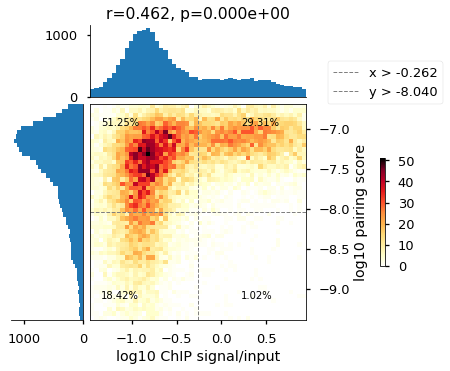

In [50]:
bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__RNAPII_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw'
x,y = get_bin_data(bw_path=bw_path, pairing=pairing_JJ17_18, use_chrX=False)
golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None)


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

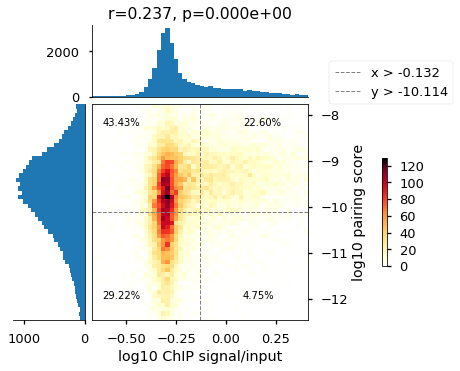

In [51]:
bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__2-3h_wt_Pol_II__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Pol_II_input__Embryo__SunRushlow2015.fc.signal.bw'
x,y = get_bin_data(bw_path=bw_path, pairing=pairing_JJ25_26, use_chrX=True)
golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None)


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


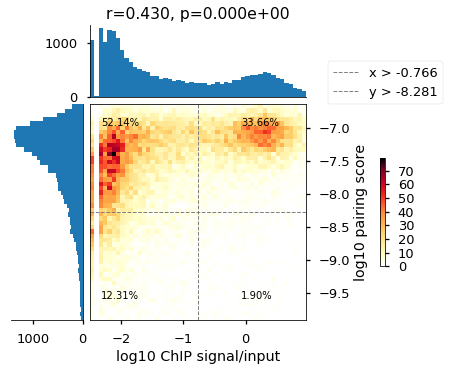

In [52]:
bw_path = pathlib.Path('/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.unstranded.all.bw')
    
x,y = get_bin_data(bw_path=bw_path, pairing=pairing_JJ17_18, use_chrX=False)
x[~np.isfinite(x)] = -2.5
golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None, percentile_range=(1,98))

# FIG_FOLDER = '/tmp/'
# figname = 'pairing__vs__' + bw_path.name.split('.unstranded')[0]
# for fmt in ['.png','.pdf']:
#     plt.savefig(
#         f'{FIG_FOLDER}/{figname}{fmt}',
#         dpi=300,
#         bbox_inches = 'tight')

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


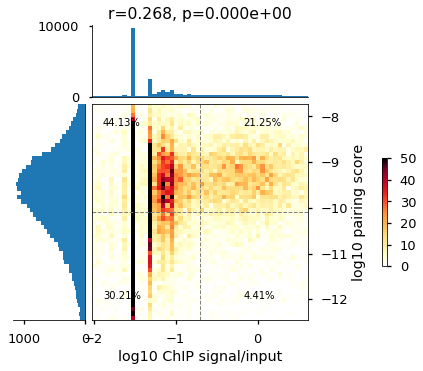

In [61]:
bw_path = pathlib.Path('/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cycle_14D_female__Embryo__LottEisen2011.unstranded.all.bw')
    
x,y = get_bin_data(bw_path=bw_path, pairing=pairing_JJ25_26, use_chrX=True)
x[~np.isfinite(x)] = -1.5
golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None, percentile_range=(2.5,97.5),
           hist2d_kwargs={'vmax':50})

FIG_FOLDER = '/tmp/'
figname = 'pairing_JJ25_26__vs__' + bw_path.name.split('.unstranded')[0]
for fmt in ['.png','.pdf']:
    plt.savefig(
        f'{FIG_FOLDER}/{figname}{fmt}',
        dpi=300,
        bbox_inches = 'tight')

## Output quadrants 

In [53]:
chroms = ['chr2L', 'chr2R', 'chr3L', 'chr3R']
pairing_JJ17_18_vs_expression = pairing_JJ17_18.copy()
pairing_JJ17_18_vs_expression['log10_expr'] = np.nan
for chrom in chroms:
    start = 0
    #end = dm3_chromsizes[chrom]
    end = int(np.ceil((dm3_chromsizes[chrom]-start)/RES) * RES)

    loc_chip = bioframe.read_bigwig_binned(
        bw_path,
        chrom,
        start,
        end,
        int(np.ceil((end-start)/RES))
    )

    pairing_JJ17_18_vs_expression['log10_expr'].loc[
        pairing_JJ17_18_vs_expression.chrom ==chrom+'_057'] = np.log10(loc_chip)
    pairing_JJ17_18_vs_expression['log10_expr'].loc[
        pairing_JJ17_18_vs_expression.chrom ==chrom+'_439'] = np.log10(loc_chip)
    

    
pairing_JJ17_18_vs_expression['quadrant'] = np.nan
log10_expr_threshold = -0.766
pairing_threshold = -8.324
pairing_JJ17_18_vs_expression.quadrant.loc[
    (pairing_JJ17_18_vs_expression.log10_expr >= log10_expr_threshold) 
     & (pairing_JJ17_18_vs_expression.pairing >= pairing_threshold)] = 1.0
pairing_JJ17_18_vs_expression.quadrant.loc[
    (pairing_JJ17_18_vs_expression.log10_expr < log10_expr_threshold) 
     & (pairing_JJ17_18_vs_expression.pairing >= pairing_threshold)] = 2.0
pairing_JJ17_18_vs_expression.quadrant.loc[
    (pairing_JJ17_18_vs_expression.log10_expr < log10_expr_threshold) 
     & (pairing_JJ17_18_vs_expression.pairing < pairing_threshold)] = 3.0
pairing_JJ17_18_vs_expression.quadrant.loc[
    (pairing_JJ17_18_vs_expression.log10_expr >= log10_expr_threshold) 
     & (pairing_JJ17_18_vs_expression.pairing < pairing_threshold)] = 4.0

pairing_JJ17_18_vs_expression.to_csv(
    '/tmp/JJ17_18.log2_pairing.vs.log10_expr.res_4000.win_24000.balanced.3R_adj.nonorm.per_hom.nanmean.tsv',
    index=False,
    sep='\t'
)

/home/golobor/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/golobor/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/golobor/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_i

## Batch plot

In [57]:
FIG_FOLDER = '/tmp/'

for bw_path in pathlib.Path('/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/').glob('*.fc.signal.bw'):
    figname = 'pairing_JJ17_18__vs__' + bw_path.name.split('.fc')[0]
    x,y = get_bin_data(bw_path=bw_path, pairing=pairing_JJ17_18, use_chrX=False)
    golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None)

    print(figname)

       
    for fmt in ['.png','.pdf']:
        plt.savefig(
            f'{FIG_FOLDER}/{figname}{fmt}',
            dpi=300,
            bbox_inches = 'tight')
    plt.close()


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__wt_Bcd_E1-3__Embryo__XuSmall2014__VS__ChIP__wt_input__Embryo__XuSmall2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_CTCF_kd__Kc167__VanBortleCorces2012__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__WT_NC14E-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC14E-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__antiH3K27me3ry__larvae__RayKassiss2016__VS__ChIP__antiH3K27me3ry-Input__larvae__RayKassiss2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__PcCBioTAP_IP__S2__KangKuroda2015__VS__ChIP__PcCBioTAP_input__S2__KangKuroda2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_MSL2_RNAi__SL2__SorucoLarschan2013__VS__ChIP__input_MSL2_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__2-3h_zld_Pol_II__Embryo__SunRushlow2015__VS__ChIP__2-3h_zld_Pol_II_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-496_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_siMrg15__SL2__HuangZhu2017__VS__ChIP__Mrg15_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27ac_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_nc14__Embryo__Reider2017__VS__ChIP__CLAMP_nc14_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__DREF_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27ac_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Dfd_E0-8__Embryo__NegreWhite2011__VS__ChIP__Dfd_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuH__Embryo__NegreWhite2011__VS__ChIP__SuH_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me3_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me3_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CapH2_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__GAF__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ash1_siMrg15__SL2__HuangZhu2017__VS__ChIP__input_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__GAF-KD_GAF__S2__FudaLis2015__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mrg15_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9ac_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pc_RJ_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__ZLD_cycle_8__Embryo__HarrisonEisen2011__VS__ChIP__cycle_8_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27ac_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__RNAPII_triptolide__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ash1_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Condensin_I_Barren_Interphase__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me3_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_interphase__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9me2_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9Ac_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BioTAPNScm_IP__S2__KangKuroda2015__VS__ChIP__BioTAPNScm_input__S2__KangKuroda2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Fs1h-L_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCTCF_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pcl_E0-8__Embryo__NegreWhite2011__VS__ChIP__Pcl_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3__Kc167__VanBortleCorces2012__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuHw__Embryo__NegreWhite2011__VS__ChIP__SuHw_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me2_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CTCF_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCTCF_interphase__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuHw_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCTCF_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF-32_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__TCF_E0-8__Embryo__NegreWhite2011__VS__ChIP__TCF_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CBP_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Chromator_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__GAF__S2__FudaLis2015__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4Me1_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pol_II_rpb3__S2__CoreLis2012__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__DREF_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9me2_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCAPD3__S2Rp__KlebanowLongworth2016__VS__ChIP__IgG__S2Rp__KlebanowLongworth2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3__Kc167__CubenasPottsCorces2017__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Zw5__Embryo__ZolotarevGeorgiev2016__VS__ChIP__input_DNA__Embryo__ZolotarevGeorgiev2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CTCF_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9ac_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__zld_Bcd_E1-3__Embryo__XuSmall2014__VS__ChIP__zld_input__Embryo__XuSmall2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mef2__Embryo__BonnFurlong2012__VS__ChIP__input__Embryo__BonnFurlong2012


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Chromator_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__mei-41_NC13-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__mei-41_NC13-IgG__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mrg15_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__zld_NC13-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__zld_NC13-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27Ac_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuHw_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Condensin_I_CAPH2_async__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Nup98__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__DREF_TOTAL__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__WT_NC14L-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC14L-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ash1_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mrg15_siMrg15__SL2__HuangZhu2017__VS__ChIP__input_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-499_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__WT_NC14M-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC14M-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ibf2__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Zelda_WT__Embryo__LiEisen2014__VS__ChIP__cycle_14c_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mrg15_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__RNAPII_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-500_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF-32_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pita__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-493_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_control_RNAi__SL2__SorucoLarschan2013__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__antiPhry__larvae__RayKassiss2016__VS__ChIP__antiPhry-Input__larvae__RayKassiss2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__WT_NC12-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC12-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-494_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ibf1__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mod_mdg4_BTB__Kc167__VanBortleCorces2012__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__L3mbt_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__ZLD_cycle_13__Embryo__HarrisonEisen2011__VS__ChIP__cycle_12_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__2-3h_wt_Dl__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Dl_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pc_VP_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF_interphase__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__2-3h_wt_Pol_II__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Pol_II_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-497_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_nc13__Embryo__Reider2017__VS__ChIP__CLAMP_nc13_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__TFIIIC_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__WT_NC13-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC13-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-495_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27me3_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27ac_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__DREF_Mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Chromator__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_nc10__Embryo__Reider2017__VS__ChIP__CLAMP_nc10_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Cohesin_Rad21_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ash1_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27Me3_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CBP_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__ZIPIC__Embryo__ZolotarevGeorgiev2016__VS__ChIP__input_DNA__Embryo__ZolotarevGeorgiev2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__2-3h_wt_Zld__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Zld_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__7T_cad_E0-4h__Embryo__NegreWhite2011__VS__ChIP__7T_cad_INPUT_E0-4h__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Condensin_II_CAPH2_Interphase__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9Me3_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27ac_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__antiPhory__larvae__RayKassiss2016__VS__ChIP__Pho__larvae__RayKassiss2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuHw_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__ZLD_cycle_14__Embryo__HarrisonEisen2011__VS__ChIP__cycle_14a_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Modmdg4_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_nc12__Embryo__Reider2017__VS__ChIP__CLAMP_nc12_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-501_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-492_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Trl_E0-8h__Embryo__NegreWhite2011__VS__ChIP__Trl_E0-8h_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Condensin_I_Barren_Asynchronous__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__GAF__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CLAMP_nc11__Embryo__Reider2017__VS__ChIP__CLAMP_nc11_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__RNAPII_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Su_var_3-9_E0-12h__Embryo__NegreWhite2011__VS__ChIP__Su_var_3-9_E0-12h_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_dZld__Embryo__LiEisen2014__VS__ChIP__H3_dZld__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF-32_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CBP_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Condensin_II_CAPH2_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pita__Embryo__ZolotarevGeorgiev2016__VS__ChIP__input_DNA__Embryo__ZolotarevGeorgiev2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me2_siMrg15__SL2__HuangZhu2017__VS__ChIP__input_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuHw_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__RNAPII_flavopiridol__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me1_WT__Embryo__LiEisen2014__VS__ChIP__H3_WT__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__2-3h_gd7_Zld__Embryo__SunRushlow2015__VS__ChIP__2-3h_gd7_Zld_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCTCF_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Rad21_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me2_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dTFIIIC220_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Pc_RJ_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Ubx_E0-12__Embryo__NegreWhite2011__VS__ChIP__Dfd_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4Me3_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Zelda_dZld__Embryo__LiEisen2014__VS__ChIP__cycle_14c_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Z4_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K36me2_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Mod_mdg4_2_2__Kc167__VanBortleCorces2012__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__L3mbt_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CapH2_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Cohesin_Rad21__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9ac_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K27ac_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCTCF_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Rad21_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K9ac_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__Fs1h-L_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__2-3h_zld_Dl__Embryo__SunRushlow2015__VS__ChIP__2-3h_zld_Dl_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__ZIPIC__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__SuHw_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__HDAC-498_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__H3K4me3_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__CP190_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__TFIIIC_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__L_3_mbt__Kc167__VanBortleCorces2012__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dTFIIIC220__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__BEAF_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing_JJ17_18__vs__ChIP__dCAPD3__S2Rp__KlebanowLongworth2016__VS__ChIP__input__S2Rp__KlebanowLongworth2016


In [58]:
FIG_FOLDER = '/tmp/'

for bw_path in pathlib.Path('/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/').glob('*.fc.signal.bw'):
    figname = 'pairing_JJ25_26__vs__' + bw_path.name.split('.fc')[0]
    x,y = get_bin_data(bw_path=bw_path, pairing=pairing_JJ25_26, use_chrX=True)
    golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None)

    print(figname)

       
    for fmt in ['.png','.pdf']:
        plt.savefig(
            f'{FIG_FOLDER}/{figname}{fmt}',
            dpi=300,
            bbox_inches = 'tight')
    plt.close()


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__wt_Bcd_E1-3__Embryo__XuSmall2014__VS__ChIP__wt_input__Embryo__XuSmall2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_CTCF_kd__Kc167__VanBortleCorces2012__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__WT_NC14E-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC14E-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__antiH3K27me3ry__larvae__RayKassiss2016__VS__ChIP__antiH3K27me3ry-Input__larvae__RayKassiss2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__PcCBioTAP_IP__S2__KangKuroda2015__VS__ChIP__PcCBioTAP_input__S2__KangKuroda2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_MSL2_RNAi__SL2__SorucoLarschan2013__VS__ChIP__input_MSL2_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__2-3h_zld_Pol_II__Embryo__SunRushlow2015__VS__ChIP__2-3h_zld_Pol_II_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-496_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_siMrg15__SL2__HuangZhu2017__VS__ChIP__Mrg15_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27ac_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_nc14__Embryo__Reider2017__VS__ChIP__CLAMP_nc14_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__DREF_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27ac_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Dfd_E0-8__Embryo__NegreWhite2011__VS__ChIP__Dfd_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuH__Embryo__NegreWhite2011__VS__ChIP__SuH_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me3_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me3_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CapH2_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__GAF__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ash1_siMrg15__SL2__HuangZhu2017__VS__ChIP__input_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__GAF-KD_GAF__S2__FudaLis2015__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mrg15_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9ac_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pc_RJ_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__ZLD_cycle_8__Embryo__HarrisonEisen2011__VS__ChIP__cycle_8_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27ac_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__RNAPII_triptolide__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ash1_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Condensin_I_Barren_Interphase__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me3_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_interphase__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9me2_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9Ac_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BioTAPNScm_IP__S2__KangKuroda2015__VS__ChIP__BioTAPNScm_input__S2__KangKuroda2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Fs1h-L_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCTCF_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pcl_E0-8__Embryo__NegreWhite2011__VS__ChIP__Pcl_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3__Kc167__VanBortleCorces2012__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuHw__Embryo__NegreWhite2011__VS__ChIP__SuHw_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me2_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CTCF_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCTCF_interphase__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuHw_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCTCF_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF-32_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__TCF_E0-8__Embryo__NegreWhite2011__VS__ChIP__TCF_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CBP_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Chromator_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__GAF__S2__FudaLis2015__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4Me1_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pol_II_rpb3__S2__CoreLis2012__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__DREF_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9me2_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCAPD3__S2Rp__KlebanowLongworth2016__VS__ChIP__IgG__S2Rp__KlebanowLongworth2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3__Kc167__CubenasPottsCorces2017__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Zw5__Embryo__ZolotarevGeorgiev2016__VS__ChIP__input_DNA__Embryo__ZolotarevGeorgiev2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CTCF_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9ac_cycle_12__Embryo__LiEisen2014__VS__ChIP__H3_cycle_12__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__zld_Bcd_E1-3__Embryo__XuSmall2014__VS__ChIP__zld_input__Embryo__XuSmall2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mef2__Embryo__BonnFurlong2012__VS__ChIP__input__Embryo__BonnFurlong2012


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Chromator_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__mei-41_NC13-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__mei-41_NC13-IgG__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mrg15_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__zld_NC13-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__zld_NC13-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27Ac_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuHw_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Condensin_I_CAPH2_async__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Nup98__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__DREF_TOTAL__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__WT_NC14L-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC14L-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ash1_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mrg15_siMrg15__SL2__HuangZhu2017__VS__ChIP__input_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-499_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__WT_NC14M-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC14M-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ibf2__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Zelda_WT__Embryo__LiEisen2014__VS__ChIP__cycle_14c_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mrg15_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__RNAPII_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-500_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF-32_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pita__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-493_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_control_RNAi__SL2__SorucoLarschan2013__VS__ChIP__input_control_RNAi__SL2__SorucoLarschan2013


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__antiPhry__larvae__RayKassiss2016__VS__ChIP__antiPhry-Input__larvae__RayKassiss2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__WT_NC12-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC12-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-494_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ibf1__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mod_mdg4_BTB__Kc167__VanBortleCorces2012__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__L3mbt_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__ZLD_cycle_13__Embryo__HarrisonEisen2011__VS__ChIP__cycle_12_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__2-3h_wt_Dl__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Dl_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pc_VP_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF_interphase__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__2-3h_wt_Pol_II__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Pol_II_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_HS__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-497_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_nc13__Embryo__Reider2017__VS__ChIP__CLAMP_nc13_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__TFIIIC_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__WT_NC13-pSer5__Embryo__BlytheWieschaus2015__VS__ChIP__WT_NC13-input__Embryo__BlytheWieschaus2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-495_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27me3_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27ac_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__DREF_Mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_cycle_14c__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14c__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Chromator__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_nc10__Embryo__Reider2017__VS__ChIP__CLAMP_nc10_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Cohesin_Rad21_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ash1_WT__SL2__HuangZhu2017__VS__ChIP__IgG_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27Me3_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CBP_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__ZIPIC__Embryo__ZolotarevGeorgiev2016__VS__ChIP__input_DNA__Embryo__ZolotarevGeorgiev2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__2-3h_wt_Zld__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Zld_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__7T_cad_E0-4h__Embryo__NegreWhite2011__VS__ChIP__7T_cad_INPUT_E0-4h__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Condensin_II_CAPH2_Interphase__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9Me3_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27ac_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__antiPhory__larvae__RayKassiss2016__VS__ChIP__Pho__larvae__RayKassiss2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuHw_20HE_3hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__ZLD_cycle_14__Embryo__HarrisonEisen2011__VS__ChIP__cycle_14a_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Modmdg4_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_nc12__Embryo__Reider2017__VS__ChIP__CLAMP_nc12_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-501_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-492_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Trl_E0-8h__Embryo__NegreWhite2011__VS__ChIP__Trl_E0-8h_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Condensin_I_Barren_Asynchronous__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__GAF__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CLAMP_nc11__Embryo__Reider2017__VS__ChIP__CLAMP_nc11_input__Embryo__Reider2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__RNAPII_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Su_var_3-9_E0-12h__Embryo__NegreWhite2011__VS__ChIP__Su_var_3-9_E0-12h_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_dZld__Embryo__LiEisen2014__VS__ChIP__H3_dZld__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF-32_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CBP_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Condensin_II_CAPH2_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pita__Embryo__ZolotarevGeorgiev2016__VS__ChIP__input_DNA__Embryo__ZolotarevGeorgiev2016


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me2_siMrg15__SL2__HuangZhu2017__VS__ChIP__input_siMrg15__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuHw_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__RNAPII_flavopiridol__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me1_WT__Embryo__LiEisen2014__VS__ChIP__H3_WT__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__2-3h_gd7_Zld__Embryo__SunRushlow2015__VS__ChIP__2-3h_gd7_Zld_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCTCF_mitosis__Kc167__YangCorces2013__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Rad21_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me2_WT__SL2__HuangZhu2017__VS__ChIP__input_WT__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dTFIIIC220_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Pc_RJ_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Ubx_E0-12__Embryo__NegreWhite2011__VS__ChIP__Dfd_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4Me3_E0-4__Embryo__NegreWhite2011__VS__ChIP__E0-4_INPUT__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Zelda_dZld__Embryo__LiEisen2014__VS__ChIP__cycle_14c_input__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Z4_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K36me2_siAsh1__SL2__HuangZhu2017__VS__ChIP__input_siAsh1__SL2__HuangZhu2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Mod_mdg4_2_2__Kc167__VanBortleCorces2012__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__L3mbt_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CapH2_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_dCTCF_RNAi__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Cohesin_Rad21__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9ac_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K27ac_cycle_14a__Embryo__LiEisen2014__VS__ChIP__H3_cycle_14a__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCTCF_20HE_0hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Rad21_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K9ac_cycle_8__Embryo__LiEisen2014__VS__ChIP__H3_cycle_8__Embryo__LiEisen2014


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__Fs1h-L_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__2-3h_zld_Dl__Embryo__SunRushlow2015__VS__ChIP__2-3h_zld_Dl_input__Embryo__SunRushlow2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__ZIPIC__Kc167__CubenasPottsCorces2017__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__SuHw_20HE_48hrs__Kc167__WoodCorces2011__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__HDAC-498_E0-12__Embryo__NegreWhite2011__VS__ChIP__HDAC-INPUT_E0-12__Embryo__NegreWhite2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__H3K4me3_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__CP190_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__TFIIIC_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__L_3_mbt__Kc167__VanBortleCorces2012__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dTFIIIC220__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__BEAF_HS__Kc167__LiCorces2015__VS__ChIP__IgG_HS__Kc167__LiCorces2015


/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48:

pairing_JJ25_26__vs__ChIP__dCAPD3__S2Rp__KlebanowLongworth2016__VS__ChIP__input__S2Rp__KlebanowLongworth2016
